# Natural Language Processing for Symptom Detection in Unstructured Provider-Patient Conversation
# 6.871 Final Project Spring 2022
# LSTM Testing and Figure Creation

This notebook contains the code to train and test the LSTM for symptom detection in clinical conversation. It also contains the methods for plotting ROC and precision-recall curves with bootstrapped errors.

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# NOTE: You may need to restart runtime after running this cell
# scipy bootstrap requires a later version of scipy than the colab default
!pip install scipy==1.7.1
from scipy import stats

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score, accuracy_score


import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
!pip install nltk

from google.colab import files

!pip install transformers
from transformers import BertTokenizer, PreTrainedTokenizer
!pip install pytorch-crf
from torchcrf import CRF

from google.colab import data_table
data_table.enable_dataframe_formatter()

### Load and Analyze Data

In [ ]:
from io import StringIO

# Upload dataframe with symptom data
uploaded = files.upload()
s = str(uploaded['df_unique.csv'], 'utf-8')
seq_df = pd.read_csv(StringIO(s))

# Binarize the 0-3 classification for symptom talk
seq_df['bin_symptoms'] = seq_df['avg_symptoms'] > 1.5

print(seq_df)
print(len(seq_df))
print(np.unique(seq_df['turn_number'].values))


In [ ]:
# Print some statistics for the data
print(np.unique(np.array(list(zip(seq_df['bin_symptoms'].values,seq_df['avg_symptoms'].values))), return_counts = True, axis = 0))
print(np.unique(seq_df['batch'], return_counts = True))
print(type(seq_df['turn_text'].iloc[10]))
print(len(np.unique(seq_df['pt_id'])))
print(seq_df.loc[seq_df['turn_number'] == 0]['turn_text'])

In [38]:
# Preprocess the data to remove stopwords nad punctuation
def remove_stopwords_punct(text):
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  tokenizer = RegexpTokenizer(r'\w+')
  no_sw_text = ' '.join(tokens_without_sw)
  tokens_without_punct = tokenizer.tokenize(no_sw_text)
  return " ".join(tokens_without_punct)

# Add a new column with the processed text
# This is what we will train on
seq_df['turn_text_raw'] = seq_df['turn_text']
seq_df['turn_text'] = seq_df['turn_text'].apply(remove_stopwords_punct)
seq_df = seq_df[seq_df.turn_text != '']
seq_df = seq_df.reset_index(drop=True)
print(len(seq_df))

79552


In [39]:
# Define a Dataset object to give to a Pytorch dataloader
class SeqDataset(Dataset):
    def __init__(self, x, y, indices):
        self.x = x[indices]
        self.y = y[indices]
        assert len(self.x) == len(self.y)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        seq = self.x[idx]
        label = self.y[idx]
        return seq, label

In [40]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import random

# get train/val/test split
def stratify_idx(df, pats, stratify_feats, split = (0.7, 0.1, 0.2), load = False, save = False):
    if load:
        train_indices = np.load("train_indices.npy")
        val_indices = np.load("val_indices.npy")
        test_indices = np.load("test_indices.npy")

    if not load:
        pt_ids, pt_lengths = np.unique(df["pt_id"], return_counts=True)
        # Set random seed for replicable result
        random.seed(42)
        # 0 for training, 1 for validation, 2 for testing
        assignment = np.array(random.choices(population=[0, 1, 2], weights=[0.8, 0.1, 0.1], k=len(pt_ids)))
        pt_train = pats[np.nonzero(assignment == 0)[0]]
        pt_val = pats[np.nonzero(assignment == 1)[0]]
        pt_test = pats[np.nonzero(assignment == 2)[0]]

        # Verify that there is no leakage
        train_df = df.query('pt_id in @pt_train')
        test_df = df.query('pt_id not in @pt_train')

        train_pt, train_pt_counts = np.unique(train_df['pt_id'].values, return_counts = True)
        test_pt, test_pt_counts = np.unique(test_df['pt_id'].values, return_counts = True)

        print(len(np.intersect1d(train_pt, test_pt)))
        # for i in np.intersect1d(train_pt, test_pt):
        #     print(f'{train_pt_counts[train_pt.tolist().index(i)]}/{test_pt_counts[test_pt.tolist().index(i)]}, {test_pt_counts[test_pt.tolist().index(i)]/(test_pt_counts[test_pt.tolist().index(i)] + train_pt_counts[train_pt.tolist().index(i)])}')


        train_indices = df.query('pt_id in @pt_train').index
        val_indices = df.query('pt_id in @pt_val').index
        test_indices = df.query('pt_id in @pt_test').index

    if save:
        np.save("pt_train", pt_train)
        np.save("pt_val", pt_val)
        np.save("pt_test", pt_test)

        np.save("train_indices", train_indices)
        np.save("val_indices", val_indices)
        np.save("test_indices", test_indices)

    return train_indices, val_indices, test_indices


In [ ]:
# Split turns on patient ID
pt_id = np.unique(seq_df['pt_id'].values)
mean_bin_symptoms = []

for i in np.unique(seq_df['pt_id'].values):
    mean_bin_symptoms = np.mean(seq_df.loc[seq_df['pt_id']== i]['bin_symptoms'].values)
mean_bin_symptoms = np.array(mean_bin_symptoms)

train_indices, val_indices, test_indices = stratify_idx(seq_df, pt_id, mean_bin_symptoms, save = True)

# Verify the train/val/test distribution
print(len(train_indices)/len(seq_df))
print(len(val_indices)/len(seq_df))
print(len(test_indices)/len(seq_df))

# Verify positive labels are stratified
print(max(train_indices))
print(np.mean(seq_df.iloc[train_indices]['bin_symptoms'].values))
print(np.mean(seq_df.iloc[val_indices]['bin_symptoms'].values))
print(np.mean(seq_df.iloc[test_indices]['bin_symptoms'].values))
seq_df.iloc[test_indices][["turn_text","avg_symptoms","bin_symptoms"]]

In [42]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-large-cased")
seq_encoding = tokenizer(list(seq_df['turn_text'].values), return_tensors = 'pt', padding = True)

In [43]:
# Tokenize text and load dataloaders
train_dataset = SeqDataset(seq_encoding['input_ids'], seq_df['bin_symptoms'].values, train_indices)
val_dataset = SeqDataset(seq_encoding['input_ids'], seq_df['bin_symptoms'].values, val_indices)
test_dataset = SeqDataset(seq_encoding['input_ids'], seq_df['bin_symptoms'].values, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#train_features, train_labels = next(iter(train_dataloader))

In [13]:
print(len(test_dataset.__getitem__(698)[0]))

331


In [14]:
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
print(len(tokenizer.get_vocab()))
print(len(train_indices))

28996
62318


### Train and Test LSTM

In [44]:
# run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom batch-weighted log loss function (NOT USED)
def log_loss(y_true, y_pred):
    return - torch.sum(torch.sum(1-y_true)*(y_true * torch.log(y_pred)) + torch.sum(y_true)*((1-y_true)*torch.log(1-y_pred)))/(len(y_true)**2)/10

# Define RNN
class SymptomClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, sentence_len, num_layers, dropout_prob):
        super(SymptomClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.sentence_len = sentence_len

        # Convert sentences to embeddings
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = True, batch_first = True)

        # Dense classifier layer
        self.linear2 = nn.Linear(2*self.sentence_len*self.hidden_dim, 1)

        # Dropout regularization to prevent overfitting
        self.dropout = nn.Dropout(p = dropout_prob)


    def forward(self, sentence):
        # Forward pass, return predicted logit

        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_dropout = self.dropout(lstm_out)
        symptom_logit = self.linear2(lstm_dropout.reshape(-1, 2*self.sentence_len*self.hidden_dim))
        return symptom_logit

Epoch 1/2
Epoch complete. Avg training loss: 1.891 \| Avg validation loss: 1.380
Epoch 2/2
Epoch complete. Avg training loss: 1.156 \| Avg validation loss: 1.202


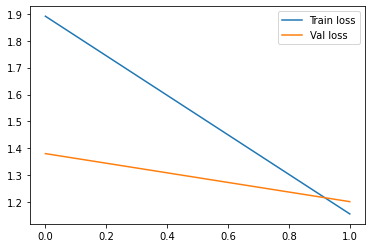

In [46]:
# TODO: parameter scan -- currently resource-limited
EMBEDDING_DIM = 64
HIDDEN_DIM = 16
ATT_DIM = 2*HIDDEN_DIM
sentence_len = 411 #331 # 411

# Initialize model
model = SymptomClassifier(EMBEDDING_DIM, HIDDEN_DIM, len(tokenizer.get_vocab()), sentence_len, 2, 0.2)
model = model.to(device)
# Define loss and optimizer
loss_function = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([20.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Run training
losses = []
val_losses = []

# validation does not consistently decrease for num_epochs > 3
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    tmp_train_losses = []
    for idx, data in enumerate(train_dataloader):
        # load data
        features = data[0].to(device)
        labels = data[1]
        labels = labels.to(device)

        # predict labels
        model.zero_grad()
        pred_labels = model(features)

        # compute losses and backprop
        loss = loss_function(torch.squeeze(pred_labels), labels.float())
        loss.backward()
        optimizer.step()
        tmp_train_losses.append(loss.cpu().detach().numpy())

    # Compute losses on val data and save
    losses.append(np.mean(np.array(tmp_train_losses)))
    model.eval()
    with torch.no_grad():

        tmp_val_losses = []
        for idx, data in enumerate(val_dataloader):
            features = data[0].to(device)
            labels = data[1]
            labels = labels.to(device)

            pred_labels = model(features)
            loss = loss_function(torch.squeeze(pred_labels), labels.float())

            tmp_val_losses.append(loss.cpu().detach().numpy())

        val_losses.append(np.mean(np.array(tmp_val_losses)))


    print(f'Epoch complete. Avg training loss: {losses[-1]:.3f} \| Avg validation loss: {val_losses[-1]:.3f}')

# Plot training and val loss over time
plt.plot(np.arange(len(losses)),losses, label = 'Train loss')
plt.plot(np.arange(len(val_losses)), val_losses, label = 'Val loss')
plt.legend(loc="upper right")
plt.show()


    

In [47]:
!pip install scipy==1.7.1
import scipy
from scipy import stats

0.8688576443443515
(0.8516767091647316, 0.8836773829838439)


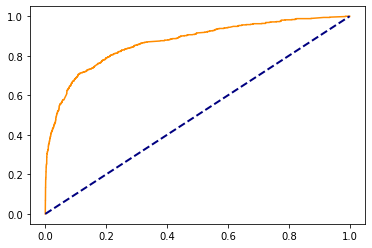

In [48]:
# See what the scores are after training
with torch.no_grad():
    model.eval()
    y_pred = []
    y_true = []
    for idx, data in enumerate(test_dataloader):
        features = data[0].to(device)

        pred_labels = model(features)
        y_pred.append(torch.squeeze(pred_labels).cpu().detach().numpy())
        y_true.append(data[1].numpy())

# Predicted and true test data
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

# Compute AUROC and bootstrap erro
print( roc_auc_score(y_true,y_pred))
roc_err = stats.bootstrap((y_true,y_pred), roc_auc_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 1000)
print((roc_err.confidence_interval.low, roc_err.confidence_interval.high))

# Plot ROC (done better in a later cell)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

In [49]:
print((-1*roc_err.confidence_interval.low + roc_err.confidence_interval.high)/2)

# Compute unweighted accuracy and bootstrap confidence interval
acc = []
for thresh in np.linspace(-10,10,1000):
    acc.append((thresh, accuracy_score(y_true,(y_pred>thresh).astype(int))))
print(max(acc,key=lambda x: x[1]))
print(stats.bootstrap((y_true,(y_pred>2.4524524524524516).astype(int)), accuracy_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples=1000))

0.016000336909556157
(3.453453453453454, 0.9247410115783059)
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9116354357099329, high=0.9248933577087142), standard_error=0.003400856441371162)


### Compare Model Performances

In [20]:
# Get threshold prediction value for a desired target recall
def get_threshold(y_true, y_pred, target_recall):
    min_val = -10
    max_val = 10

    # binary search
    while np.abs(max_val - min_val) > 1e-4:
        current_thresh = (max_val + min_val)/2

        if recall_score(y_true, y_pred > current_thresh) > target_recall:
            min_val = current_thresh
        else:
            max_val = current_thresh
    return current_thresh

# Manual bootstrap confidence interval calculations (NOT USED)
def bootstrap(y_true,y_pred, n = 1):
    data = np.stack([y_true,y_pred]).T
    print(data.shape)
    pred_precision = []
    for i in range(n):
        idx = np.random.choice(np.arange(data.shape[0]), data.shape[0])
        pred_precision.append(precision_score(data[idx, 0], data[idx,1]))
    pred_precision = np.array(pred_precision)
    return [np.percentile(pred_precision, 2.5), np.percentile(pred_precision, 97.5)]


In [21]:
# Save LSTM results to load results from all models
np.save('y_true_lstm', y_true)
np.save('y_pred_lstm', y_pred)

### ROC Curve

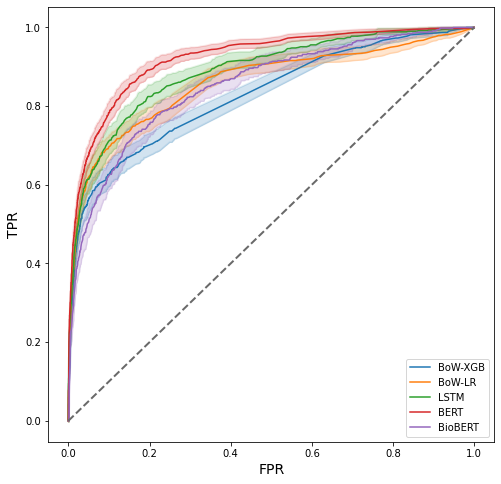

In [26]:
# test results from other models to load
ground_truths = ['y_true (1).npy','y_true_bowlr.npy', 'y_true_lstm.npy','y_true.npy','y_true_biobert.npy']
preds_list = ['y_preds_xgb_preprocessed (1).npy','y_pred_bowlr.npy','y_pred_lstm.npy','y_pred_bert_preprocessed.npy','y_pred_biobert.npy']
label = ['BoW-XGB', 'BoW-LR','LSTM','BERT','BioBERT']
color = ['C0','C1','C2','C3','C4']

# Get tpr given binarized prediction values
def get_tpr(y_true, y_pred):
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))

    return tp / (tp + fn)


plt.figure(figsize = (8,8))
for y_true_name, y_pred_name, label,color in list(zip(ground_truths, preds_list, label,color)):
    # For each model, load data
    y_true = np.squeeze(np.load(y_true_name))
    y_pred = np.squeeze(np.load(y_pred_name))

    if 'bowlr' in y_pred_name:
        y_pred = y_pred[:,1]

    # Sample 1000 threshold values to compute (fpr, tpr) pairs
    mean_fpr = []
    mean_tpr = []
    err_tpr = []
    for thresh in np.linspace(np.amin(y_pred), np.amax(y_pred), 1000):
        # Calculate confusion matrix entries
        fp = np.sum(((y_pred > thresh).astype(int) == 1) & (y_true == 0))
        tp = np.sum(((y_pred > thresh).astype(int) == 1) & (y_true == 1))

        fn = np.sum(((y_pred > thresh).astype(int) == 0) & (y_true == 1))
        tn = np.sum(((y_pred > thresh).astype(int) == 0) & (y_true == 0))

        # compute average fpr and tpr at a given threshold
        mean_fpr.append(fp / (fp + tn))
        mean_tpr.append(tp / (tp + fn))

        # Bootstrap confidence interval for every point on ROC curve
        bootstrap_p = stats.bootstrap((y_true,(y_pred > thresh).astype(int)), get_tpr, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 250)
        err_tpr.append([bootstrap_p.confidence_interval.low, bootstrap_p.confidence_interval.high])
    
    # Plot with 95% confidence interval
    yerr = np.abs(np.array(err_tpr).T - np.array(mean_tpr))
    plt.plot(mean_fpr, mean_tpr, '-',label = label,color=color)
    plt.plot(mean_fpr, np.array(err_tpr)[:,0], color = color, alpha = 0.1)
    plt.plot(mean_fpr, np.array(err_tpr)[:,1], color = color, alpha = 0.1)
    plt.fill_between(x = mean_fpr, y1 = np.array(err_tpr)[:,0], y2 = np.array(err_tpr)[:,1], color = color, alpha = 0.2)

# Format and label plot
plt.plot([0, 1], [0, 1], color="dimgray", lw=2, linestyle="--")
plt.xlabel('FPR',fontsize = 14)
plt.ylabel('TPR',fontsize = 14)
plt.legend()
plt.show()

### Precision-Recall Curve

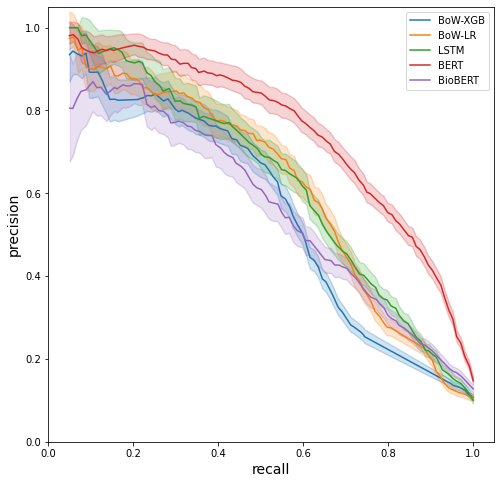

In [27]:
# test results from other models to load
ground_truths = ['y_true (1).npy','y_true_bowlr.npy', 'y_true_lstm.npy','y_true.npy','y_true_biobert.npy']
preds_list = ['y_preds_xgb_preprocessed (1).npy','y_pred_bowlr.npy','y_pred_lstm.npy','y_pred_bert_preprocessed.npy','y_pred_biobert.npy']
label = ['BoW-XGB', 'BoW-LR','LSTM','BERT','BioBERT']
color = ['C0','C1','C2','C3','C4']

plt.figure(figsize = (8,8))
for y_true_name, y_pred_name, label,color in list(zip(ground_truths, preds_list, label,color)):
    # For each model, load data
    y_true = np.squeeze(np.load(y_true_name))
    y_pred = np.squeeze(np.load(y_pred_name))
    if 'bowlr' in y_pred_name:
        y_pred = y_pred[:,1]
    
    # Sample 100 values of the recall and compute (recall, precision) pairs
    mean_r = []
    mean_p = []
    err_p = []
    for rec in np.linspace(0.05, 1.0, 100):
        # Get threshold associated with given recall
        thresh = get_threshold(y_true,y_pred, rec)

        # Compute precision and recall at this threshold
        mean_p.append(precision_score(y_true, y_pred > thresh))
        mean_r.append(recall_score(y_true, y_pred > thresh))

        # Bootstrap confidence interval for precision
        bootstrap_p = stats.bootstrap((y_true,y_pred > thresh), precision_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples = 250)
        err_p.append([bootstrap_p.confidence_interval.low, bootstrap_p.confidence_interval.high])
        
    # Plot
    yerr = np.abs(np.array(err_p).T - np.array(mean_p))
    plt.plot(mean_r, mean_p, '-',label = label,color=color)
    plt.plot(mean_r, np.array(err_p)[:,0], color = color, alpha = 0.1)
    plt.plot(mean_r, np.array(err_p)[:,1], color = color, alpha = 0.1)
    plt.fill_between(x = mean_r, y1 = np.array(err_p)[:,0], y2 = np.array(err_p)[:,1], color = color, alpha = 0.2)
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.xlabel('recall',fontsize = 14)
plt.ylabel('precision',fontsize = 14)
plt.legend()
plt.show()

### Evaluation statistics for other models

In [34]:
y_true_bow = np.load('y_true.npy')
print(y_true_bow.shape)
y_pred_bow = np.load('y_pred_bert_preprocessed.npy')
# y_pred_bow = y_pred_bow[:,1]

# Accuracy calculation, get best accuracy
acc = []
for thresh in np.linspace(-10,10,1000):
    acc.append((thresh, accuracy_score(y_true_bow,(y_pred_bow>thresh).astype(int))))
print(max(acc,key=lambda x: x[1]))
print(stats.bootstrap((y_true_bow,(y_pred_bow>0.37037037037).astype(int)), accuracy_score, vectorized = False, paired = True, random_state = 42, method = 'basic', n_resamples=1000))

(6781, 1)
(6781, 1)
0.0014408962
0.98302346
(array([0, 1]), array([5782,  999]))
5234
0.9229374653103466
(0.5305305305305303, 0.9162365432827017)
BootstrapResult(confidence_interval=ConfidenceInterval(low=array([0.90650347]), high=array([0.92007079])), standard_error=array([0.00347834]))


In [ ]:
# compute best precision-recall pair
for i, value in enumerate(zip(mean_r,mean_p)):
    r,p = value[0], value[1]
    print(i, (r + p - 1), r, p)
print(err_p[11])

### Qualitative Analysis

In [ ]:
# Create new dataframe with predicted results
test_res_df = seq_df.iloc[test_indices][["turn_text","turn_text_raw"]].reset_index()
test_res_df["ground_truth"] = y_true
test_res_df["pred"] = y_pred
test_res_df["bin_pred"] = y_pred > get_threshold(y_true,y_pred,0.9)

print(test_res_df.iloc[78])

In [ ]:
# Print false negatives
test_res_df.loc[(test_res_df["ground_truth"] == 1) & (test_res_df["bin_pred"] == 0)]

In [ ]:
# Get context
seq_df.iloc[[11862,11863]]['turn_text']

In [ ]:
# Print false positives
test_res_df.loc[(test_res_df["ground_truth"] == 0) & (test_res_df["bin_pred"] == 1)]

In [ ]:
test_seq_df = seq_df.iloc[test_indices].reset_index(drop=True)
test_seq_df.iloc[test_res_df.loc[(test_res_df["ground_truth"] == 1) & (test_res_df["bin_pred"] == 0)].index][["turn_text","avg_symptoms","bin_symptoms"]]